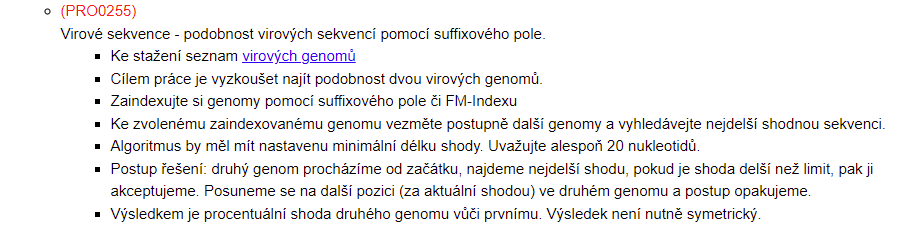

https://homel.vsb.cz/~vas218/bio.html

# Načtení genomů

In [95]:
import os
from os.path import isfile, join, isdir
import pandas as pd
import numpy as np
import functools
from pysuffixarray.core import SuffixArray
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
"""
Cesta k adresáři, který obsahuje složky s fna soubory.
"""
path_to_folder = '.\genomes'

In [3]:
"""
Předzpracování genomu, neboli vytvoření jednoho dlouhého stringu a odstranění prvního řádku s metadaty.

- Zároveň některé fna soubory obsahovaly více jak jeden genom. Dochází k získání všech částí.
- Genom je normalizován pomocí upper case metody, čímž se odstraní opakující se sekvence (malé písmena).
"""
def preprocess_genome(genome, path):
    genome = genome.upper()
    
    genomes = []
    
    current_name = ''
    current_genome = []
    
    
    
    for line in genome.split('\n'):
        if '>' in list(line):
            if current_genome:
                genomes.append((current_name[1:], current_genome))
                current_genome = []
                current_name = ''
            current_name = line
        else:
            current_genome.append(line)

    if current_genome:
        genomes.append((current_name[1:], current_genome))
    
    result = []
    for g in genomes:
        name, lines = g
        result.append((name, ''.join(lines)))
        
    return result

In [4]:
"""
Načtení genomu ze zadané cesty.
"""
def load_genome(path):
    with open(path,'r',encoding='utf-8') as f:
        genome = f.read()
    return preprocess_genome(genome, path)

In [5]:
"""
Načtení genomu z jednotlivých adresářů a uložení do slovníku. {jméno: sekvence}
"""
def load_genomes_from_folder(path):
    res = {}
    directories = os.listdir(path)
    for dire in directories:
        path_to_directory = os.path.join(path, dire)
        if isdir(path_to_directory):
            for genome_file in os.listdir(path_to_directory):
                if isfile(os.path.join(path_to_directory, genome_file)):
                    genomes = load_genome(os.path.join(path_to_directory, genome_file))
                    for g in genomes:
                        name, genom = g
                        res[name] = genom            
    return res           

In [6]:
genomes = load_genomes_from_folder(path_to_folder);

In [7]:
len(list(genomes.keys()))

131

In [8]:
list(genomes.keys())

['NC_040671.1 ADENO-ASSOCIATED VIRUS ISOLATE MHH-05-2015, COMPLETE GENOME',
 'NC_038306.1 HUMAN COXSACKIEVIRUS A2 STRAIN FLEETWOOD, COMPLETE GENOME',
 'NC_007605.1 HUMAN GAMMAHERPESVIRUS 4, COMPLETE GENOME',
 'NC_005222.1 HANTAAN VIRUS SEGMENT L, COMPLETE GENOME',
 'NC_005219.1 HANTAAN VIRUS, COMPLETE GENOME',
 'NC_005218.1 HANTAAN VIRUS, COMPLETE GENOME',
 'NC_001489.1 HEPATITIS A VIRUS, COMPLETE GENOME',
 'NC_003977.2 HEPATITIS B VIRUS (STRAIN AYW) GENOME',
 'NC_004102.1 HEPATITIS C VIRUS GENOTYPE 1, COMPLETE GENOME',
 'NC_001653.2 HEPATITIS DELTA VIRUS, COMPLETE GENOME',
 'NC_001434.1 HEPATITIS E VIRUS, COMPLETE GENOME',
 'NC_011203.1 HUMAN ADENOVIRUS B1, COMPLETE GENOME',
 'AC_000018.1 HUMAN ADENOVIRUS TYPE 7, COMPLETE GENOME',
 'AC_000017.1 HUMAN ADENOVIRUS TYPE 1, COMPLETE GENOME',
 'AC_000007.1 HUMAN ADENOVIRUS 2, COMPLETE GENOME',
 'AC_000008.1 HUMAN ADENOVIRUS 5, COMPLETE GENOME',
 'NC_003266.2 HUMAN ADENOVIRUS E, COMPLETE GENOME',
 'NC_001943.1 HUMAN ASTROVIRUS, COMPLETE GENO

# Metody k suffixovému poli

In [9]:
"""
Nalezne všechny pozice, kde P se vyskytuje v T.
"""
def find_positions_index(array_index, index, P, T):
    positions = [array_index[index]]
    
    #Prohledání směrem dolu
    down = index
    while True:
        down -= 1
        if down < 0:
            break
        index_value = array_index[down]
        if not startswith(index_value, T, P):
            break
        else:
            positions.append(array_index[down])
             
    #Prohledání směrem nahoru
    up = index
    while True:
        up += 1
        if up > (len(array_index) - 1):
            break
        index_value = array_index[up]
        if not startswith(index_value, T, P):
            break
        else:
            positions.append(array_index[up])                
    return positions

In [10]:
"""
Pomocná metoda, která vyzkouší zda T začíná P.
"""
def startswith(index, T, P):
    for i in range(len(P)):
        pattern_c = P[i]
        ref_c = T[i+index]
        if pattern_c != ref_c:
            return False    
    return True

In [11]:
"""
Pomocná metoda, která indexově porovná dva řetězce T a P.
"""
def is_smaller(index, T, P):
    for i in range(len(P)):
        pattern_c = P[i]
        ref_c = T[i+index]
        if pattern_c == ref_c:
            continue        
        if pattern_c < ref_c:
            return True
        else:
            return False

In [12]:
"""
Binární vyhledávání vzhledem k suffixovému poli.
"""
def binary_search_index(array_index, P, T):
    
    mid = 0
    start = 0
    end = len(array_index)
    step = 0
    
    while (start < end):
        step = step+1
        mid = (start + end) // 2
        
        if startswith(array_index[mid], T, P):
            return find_positions_index(array_index, mid, P, T)
        
        if is_smaller(array_index[mid], T, P):
            end = mid - 1
            
        else:
            start = mid + 1
            
    return []

In [13]:
"""
Metoda, která porovná dva stringy indexově.
"""

def compare(x0, x1, T): 
    if x0 > (len(T)-1):
        return -1

    if x1 > (len(T)-1):
        return 1

    if T[x0] > T[x1]:
        return 1

    if T[x0] < T[x1]:
        return -1

    return compare(x0+1, x1+1, T)

In [14]:
"""
Metoda na vytvoření suffixového pole.
"""
def create_suffix_array_index(T):
    indicies = list(range(len(T)))
    indicies = sorted(indicies, key=functools.cmp_to_key(lambda x1, x2: compare(x1, x2, T)))
    return indicies

In [15]:
"""
Metoda na vytvoření suffixového pole.
"""
def create_suffix_array_index(T):
    sa = SuffixArray(T)
    return sa.suffix_array()[1:]
    indicies = list(range(len(T)))
    indicies = sorted(indicies, key=functools.cmp_to_key(lambda x1, x2: compare(x1, x2, T)))
    return indicies

# Post processing

In [16]:
"""
Metoda, která vstupní sekvence intervalů poshlukuje vzhledem k překrytí.
"""
def range_overlap_adjust(list_ranges):    
    overlap_corrected = []
    for start, stop in sorted(list_ranges):
        if overlap_corrected and start-1 <= overlap_corrected[-1][1] and stop >= overlap_corrected[-1][1]:
            overlap_corrected[-1] = min(overlap_corrected[-1][0], start), stop
        elif overlap_corrected and start <= overlap_corrected[-1][1] and stop <= overlap_corrected[-1][1]:
            break
        else:
            overlap_corrected.append((start, stop))
    return overlap_corrected

In [17]:
"""
Metoda, která ze vstupní pozice a počtu symbolů vytvoří intervaly.
"""
def create_ranges(sequences):
    ranges = []
    
    for s in sequences:
        start, number_of_characters = s
        ranges.append((start, start+number_of_characters))
        
    return ranges

In [18]:
"""
Metoda, která vrátí počet symbolů z dané sekvence vzhledem z vstupních intervalů.
"""
def get_size(ranges):
    counter = 0
    for r in ranges:
        start, end = r
        size = end - start
        counter += size
    return counter

In [19]:
"""
Metoda, která provede zpracování výsledku, potom co proběhne algoritmus. Zpracuje nalezené pozice, vytvoří intervaly a vrátí pokrytí prvního genomu vzhledem k druhému genomu. 
"""
def postprocess(sequences, current_genom):
    ranges = create_ranges(sequences)
    adjusted_ranges = range_overlap_adjust(ranges)
    count = get_size(adjusted_ranges)
    size_of_current_genom = len(current_genom) - 1 #cause of $
    return count / size_of_current_genom

# Vypočtení podobnosti

In [20]:
"""
Metoda, která provede získání mapování sekvencí vzhledem k definovanému oknu. Pokud bylo okno nalezeno, pak se posuneme o celé okno. 
Pokud nenalezneme, pak se posuneme pouze o jeden znak.

other_genom: sekvence genomu
current_suffix_array_genom: vypočtené suffixové pole pro aktuální genom
current_genom: sekvence aktuálního genomu + $
min_length: definované okno
"""
def get_similarity(other_genom, current_suffix_array_genom, current_genom, min_length):
    length_of_other = len(other_genom)
    stop = False
    
    #dictionary for optimalization
    sequences = []
    
    #dořešit velikost přes!
    current_index_end = length_of_other - 1
    current_index_start = current_index_end - min_length
    
    while True:
        current_sequence = other_genom[current_index_start:current_index_end]
        result = binary_search_index(current_suffix_array_genom, current_sequence, current_genom)

        exists = len(result) > 0
        
        if exists:
            #Move with whole window
            modified_result = list(zip(result, [len(current_sequence)]*len(result)))
            sequences.extend(modified_result)
            
            size_of_current_sequence = len(current_sequence)
            current_index_start -= size_of_current_sequence
            current_index_end -= size_of_current_sequence
        else:
            #Move only 
            current_index_start -= 1
            current_index_end -= 1
            
        last_move = 0
        
        if stop:
            break
        
        if current_index_start < 0:
            last_move = abs(current_index_start)
            current_index_start += last_move
            current_index_end += last_move
            stop = True
            
    return postprocess(sequences, current_genom)

In [21]:
"""
Metoda, která provede získání podobnosti jednoho genomu vůči všem ostatním,


target_key: gen jedna, ke kterému se bude získavat podobnost (klíč z data)
all_keys: všechny ostatní genomy (jejich klíče z data)
data: vstupní data, v datové struktuře slovníku, jméno: genom
current_suffix_array: vypočtené suffixové pole pro aktuální genom
current_genom: sekvence aktuálního genomu + $
min_length: definované okno
"""
def similarity_for_from(target_key, all_keys, data, current_suffix_array, current_genom, min_length):  
    df = pd.DataFrame(index=[target_key]) 
    filtered = list(filter(lambda x: x != target_key, all_keys))
        
    for other_key in all_keys:
        #print(f'{target_key} -- {len(data[target_key])} {other_key} -- {len(data[other_key])}')
        if other_key == target_key:
            df.loc[target_key, other_key] = '-'
            continue
        df.loc[target_key, other_key] = get_similarity(data[other_key], current_suffix_array, current_genom, min_length)
                
    return df

# Konfigurace

In [22]:
MIN_LENGTH = 10
#import sys, threading
#sys.setrecursionlimit(10**7) # max depth of recursion

# Výpočet

In [86]:
"""
Metoda, která provede získání podobnosti pro celý vstupní dataset

genomes: vstupní data, v datové struktuře slovníku, jméno: genom
min_length: definované okno
"""

def calculate_table(genomes, min_length=MIN_LENGTH, limit=None):
    
    all_keys = list(genomes.keys())
    frames = []
    counter = 0
    for target_key in all_keys:
        print(target_key)
        current_genom = genomes[target_key] + "$"
        current_suffix_array_for_target = create_suffix_array_index(genomes[target_key])
        
        df = similarity_for_from(target_key, all_keys, genomes, current_suffix_array_for_target, current_genom, min_length)
        
        frames.append(df)
        del current_suffix_array_for_target
        
        counter += 1
        if limit and counter >= limit:
            break
        
    return pd.concat(frames)

# Výpočet podobnosti

In [24]:
%%time

dataframe = calculate_table(genomes, MIN_LENGTH);

NC_040671.1 ADENO-ASSOCIATED VIRUS ISOLATE MHH-05-2015, COMPLETE GENOME
NC_038306.1 HUMAN COXSACKIEVIRUS A2 STRAIN FLEETWOOD, COMPLETE GENOME
NC_007605.1 HUMAN GAMMAHERPESVIRUS 4, COMPLETE GENOME
NC_005222.1 HANTAAN VIRUS SEGMENT L, COMPLETE GENOME
NC_005219.1 HANTAAN VIRUS, COMPLETE GENOME
NC_005218.1 HANTAAN VIRUS, COMPLETE GENOME
NC_001489.1 HEPATITIS A VIRUS, COMPLETE GENOME
NC_003977.2 HEPATITIS B VIRUS (STRAIN AYW) GENOME
NC_004102.1 HEPATITIS C VIRUS GENOTYPE 1, COMPLETE GENOME
NC_001653.2 HEPATITIS DELTA VIRUS, COMPLETE GENOME
NC_001434.1 HEPATITIS E VIRUS, COMPLETE GENOME
NC_011203.1 HUMAN ADENOVIRUS B1, COMPLETE GENOME
AC_000018.1 HUMAN ADENOVIRUS TYPE 7, COMPLETE GENOME
AC_000017.1 HUMAN ADENOVIRUS TYPE 1, COMPLETE GENOME
AC_000007.1 HUMAN ADENOVIRUS 2, COMPLETE GENOME
AC_000008.1 HUMAN ADENOVIRUS 5, COMPLETE GENOME
NC_003266.2 HUMAN ADENOVIRUS E, COMPLETE GENOME
NC_001943.1 HUMAN ASTROVIRUS, COMPLETE GENOME
NC_001731.1 MOLLUSCUM CONTAGIOSUM VIRUS SUBTYPE 1, COMPLETE GENOME


## Jupyter DataFrame - Vizualization

In [25]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [26]:
dataframe

,"NC_040671.1 ADENO-ASSOCIATED VIRUS ISOLATE MHH-05-2015, COMPLETE GENOME","NC_038306.1 HUMAN COXSACKIEVIRUS A2 STRAIN FLEETWOOD, COMPLETE GENOME","NC_007605.1 HUMAN GAMMAHERPESVIRUS 4, COMPLETE GENOME","NC_005222.1 HANTAAN VIRUS SEGMENT L, COMPLETE GENOME","NC_005219.1 HANTAAN VIRUS, COMPLETE GENOME","NC_005218.1 HANTAAN VIRUS, COMPLETE GENOME","NC_001489.1 HEPATITIS A VIRUS, COMPLETE GENOME",NC_003977.2 HEPATITIS B VIRUS (STRAIN AYW) GENOME,"NC_004102.1 HEPATITIS C VIRUS GENOTYPE 1, COMPLETE GENOME","NC_001653.2 HEPATITIS DELTA VIRUS, COMPLETE GENOME","NC_001434.1 HEPATITIS E VIRUS, COMPLETE GENOME","NC_011203.1 HUMAN ADENOVIRUS B1, COMPLETE GENOME","AC_000018.1 HUMAN ADENOVIRUS TYPE 7, COMPLETE GENOME","AC_000017.1 HUMAN ADENOVIRUS TYPE 1, COMPLETE GENOME","AC_000007.1 HUMAN ADENOVIRUS 2, COMPLETE GENOME","AC_000008.1 HUMAN ADENOVIRUS 5, COMPLETE GENOME","NC_003266.2 HUMAN ADENOVIRUS E, COMPLETE GENOME","NC_001943.1 HUMAN ASTROVIRUS, COMPLETE GENOME","NC_001731.1 MOLLUSCUM CONTAGIOSUM VIRUS SUBTYPE 1, COMPLETE GENOME","NC_006577.2 HUMAN CORONAVIRUS HKU1, COMPLETE GENOME","NC_005831.2 HUMAN CORONAVIRUS NL63, COMPLETE GENOME","NC_006213.1 HUMAN CORONAVIRUS OC43 STRAIN ATCC VR-759, COMPLETE GENOME","NC_002645.1 HUMAN CORONAVIRUS 229E, COMPLETE GENOME","NC_006273.2 HUMAN HERPESVIRUS 5 STRAIN MERLIN, COMPLETE GENOME","NC_038308.1 HUMAN ENTEROVIRUS 68 STRAIN FERMON, COMPLETE GENOME","NC_001806.2 HUMAN HERPESVIRUS 1 STRAIN 17, COMPLETE GENOME","NC_001798.2 HUMAN HERPESVIRUS 2 STRAIN HG52, COMPLETE GENOME","NC_000898.1 HUMAN HERPESVIRUS 6B, COMPLETE GENOME","NC_001664.4 HUMAN BETAHERPESVIRUS 6A, VARIANT A DNA, COMPLETE VIRION GENOME, ISOLATE U1102","NC_001716.2 HUMAN HERPESVIRUS 7, COMPLETE GENOME","NC_009333.1 HUMAN HERPESVIRUS 8 STRAIN GK18, COMPLETE GENOME","NC_001802.1 HUMAN IMMUNODEFICIENCY VIRUS 1, COMPLETE GENOME","NC_001356.1 HUMAN PAPILLOMAVIRUS - 1, COMPLETE GENOME",NC_001576.1 HUMAN PAPILLOMAVIRUS TYPE 10 GENOMIC DNA,M14119.1 HUMAN PAPILLOMAVIRUS TYPE 11 (HPV-11) COMPLETE GENOME,"GI|396910|LCL|HPV12REF.1| HUMAN PAPILLOMAVIRUS 12 (HPV12), COMPLETE GENOME","GI|60295|LCL|HPV13REF.1| HUMAN PAPILLOMAVIRUS 13 (HPV13), COMPLETE GENOME","GI|396918|LCL|HPV14REF.1| HUMAN PAPILLOMAVIRUS 14 (HPV14), COMPLETE GENOME","NC_001526.4 HUMAN PAPILLOMAVIRUS TYPE 16, COMPLETE GENOME","NC_001357.1 HUMAN PAPILLOMAVIRUS - 18, COMPLETE GENOME","GI|9626032|LCL|HPV2REF.1| HUMAN PAPILLOMAVIRUS 2 (HPV2), COMPLETE GENOME","NC_001583.1 HUMAN PAPILLOMAVIRUS TYPE 26, COMPLETE GENOME","GI|397005|LCL|HPV3REF.1| HUMAN PAPILLOMAVIRUS 3 (HPV3), COMPLETE GENOME",NC_038889.1 HUMAN PAPILLOMAVIRUS TYPE 30 GENOMIC DNA,"NC_001586.1 HUMAN PAPILLOMAVIRUS TYPE 32, COMPLETE GENOME","NC_001587.1 HUMAN PAPILLOMAVIRUS TYPE 34, COMPLETE GENOME","GI|333245|LCL|HPV39REF.1| HUMAN PAPILLOMAVIRUS 39 (HPV39), COMPLETE GENOME","NC_001457.1 HUMAN PAPILLOMAVIRUS TYPE 4, COMPLETE GENOME","NC_001354.1 HUMAN PAPILLOMAVIRUS TYPE 41, COMPLETE GENOME","NC_001690.1 HUMAN PAPILLOMAVIRUS TYPE 48, COMPLETE GENOME","NC_001591.1 HUMAN PAPILLOMAVIRUS TYPE 49, COMPLETE GENOME","NC_001531.1 HUMAN PAPILLOMOAVIRUS TYPE 5, COMPLETE GENOME","NC_001691.1 HUMAN PAPILLOMAVIRUS TYPE 50, COMPLETE GENOME","NC_001676.1 HUMAN PAPILLOMAVIRUS 54, COMPLETE GENOME","NC_001355.1 HUMAN PAPILLOMAVIRUS TYPE 6B, COMPLETE GENOME","NC_001693.1 HUMAN PAPILLOMAVIRUS TYPE 60, COMPLETE GENOME","NC_001694.1 HUMAN PAPILLOMAVIRUS - 61, COMPLETE GENOME","NC_001458.1 HUMAN PAPILLOMAVIRUS TYPE 63, COMPLETE GENOME",NC_001595.1 HUMAN PAPILLOMAVIRUS TYPE 7 GENOMIC DNA,"NC_039089.1 HUMAN PAPILLOMAVIRUS TYPE 71 DNA, COMPLETE GENOME","GI|333074|LCL|HPV8REF.1| HUMAN PAPILLOMAVIRUS 8 (HPV8), COMPLETE GENOME","NC_001596.1 HUMAN PAPILLOMAVIRUS TYPE 9, COMPLETE GENOME","NC_000883.2 HUMAN PARVOVIRUS B19, COMPLETE GENOME","NC_001538.1 BK POLYOMAVIRUS, COMPLETE GENOME","NC_001699.1 JC POLYOMAVIRUS, COMPLETE GENOME","NC_038235.1 HUMAN ORTHOPNEUMOVIRUS SUBGROUP A, COMPLETE CDS",U21247.1 HUMAN SPUMARETROVIRUS COMPLETE GENOME,"NC_002023.1 INFLUE

In [34]:
dataframe = dataframe.replace('-', 0)

In [37]:
indicies_for_g1 = dataframe.idxmax(axis=1)

In [50]:
dataframe.shape

(131, 131)

In [57]:
matches = []

for i in range(dataframe.shape[0]):
    access_key = indicies_for_g1.values[i]
    current_gen = list(dataframe.index)[i]
    row = dataframe.iloc[i]
    value = row[access_key]
    matches.append((current_gen, access_key, value))

In [61]:
sorted_matches = sorted(matches, key=lambda x: x[2], reverse=True)

In [62]:
sorted_matches

[('NC_011203.1 HUMAN ADENOVIRUS B1, COMPLETE GENOME',
  'AC_000018.1 HUMAN ADENOVIRUS TYPE 7, COMPLETE GENOME',
  0.8151260504201681),
 ('AC_000018.1 HUMAN ADENOVIRUS TYPE 7, COMPLETE GENOME',
  'NC_011203.1 HUMAN ADENOVIRUS B1, COMPLETE GENOME',
  0.8150588500309737),
 ('NC_007544.1 ROTAVIRUS C SEGMENT 7, COMPLETE SEQUENCE',
  'NC_001716.2 HUMAN HERPESVIRUS 7, COMPLETE GENOME',
  0.7811023622047244),
 ('AC_000017.1 HUMAN ADENOVIRUS TYPE 1, COMPLETE GENOME',
  'AC_000007.1 HUMAN ADENOVIRUS 2, COMPLETE GENOME',
  0.7781450515263465),
 ('AC_000007.1 HUMAN ADENOVIRUS 2, COMPLETE GENOME',
  'AC_000017.1 HUMAN ADENOVIRUS TYPE 1, COMPLETE GENOME',
  0.7773047277179509),
 ('AC_000008.1 HUMAN ADENOVIRUS 5, COMPLETE GENOME',
  'AC_000007.1 HUMAN ADENOVIRUS 2, COMPLETE GENOME',
  0.7647893594523902),
 ('NC_001545.2 RUBELLA VIRUS, COMPLETE GENOME',
  'NC_001731.1 MOLLUSCUM CONTAGIOSUM VIRUS SUBTYPE 1, COMPLETE GENOME',
  0.748719524687564),
 ('NC_011501.2 ROTAVIRUS A SEGMENT 7, COMPLETE GENOME',


## Excel - Save to File

In [27]:
path = 'output2.csv'
encoding = 'utf-8'

In [28]:
dataframe.to_csv(path, sep=';', encoding=encoding)  

## Plot

Průměrná maximální shoda, která lze využít pro optimalizaci

In [87]:
def test_window_size(genomes, f, t, limit=1):
    res = []
    for i in range(f, t, 1):
        print(f'Current size {i}')
        current_df =  calculate_table(genomes, i, limit);
        res.append(
            {
                'window': i,
                'res': np.mean(current_df.max(axis=1).values)
            }
        )
    return res

In [88]:
test_window_size_result = test_window_size(genomes, 5, 30, 2)

Current size 5
NC_040671.1 ADENO-ASSOCIATED VIRUS ISOLATE MHH-05-2015, COMPLETE GENOME
NC_038306.1 HUMAN COXSACKIEVIRUS A2 STRAIN FLEETWOOD, COMPLETE GENOME
Current size 6
NC_040671.1 ADENO-ASSOCIATED VIRUS ISOLATE MHH-05-2015, COMPLETE GENOME
NC_038306.1 HUMAN COXSACKIEVIRUS A2 STRAIN FLEETWOOD, COMPLETE GENOME
Current size 7
NC_040671.1 ADENO-ASSOCIATED VIRUS ISOLATE MHH-05-2015, COMPLETE GENOME
NC_038306.1 HUMAN COXSACKIEVIRUS A2 STRAIN FLEETWOOD, COMPLETE GENOME
Current size 8
NC_040671.1 ADENO-ASSOCIATED VIRUS ISOLATE MHH-05-2015, COMPLETE GENOME
NC_038306.1 HUMAN COXSACKIEVIRUS A2 STRAIN FLEETWOOD, COMPLETE GENOME
Current size 9
NC_040671.1 ADENO-ASSOCIATED VIRUS ISOLATE MHH-05-2015, COMPLETE GENOME
NC_038306.1 HUMAN COXSACKIEVIRUS A2 STRAIN FLEETWOOD, COMPLETE GENOME
Current size 10
NC_040671.1 ADENO-ASSOCIATED VIRUS ISOLATE MHH-05-2015, COMPLETE GENOME
NC_038306.1 HUMAN COXSACKIEVIRUS A2 STRAIN FLEETWOOD, COMPLETE GENOME
Current size 11
NC_040671.1 ADENO-ASSOCIATED VIRUS ISOLAT

In [89]:
test_window_size_result

[{'window': 5, 'res': 0.9996620708299541},
 {'window': 6, 'res': 0.9995268991619357},
 {'window': 7, 'res': 0.9993241416599081},
 {'window': 8, 'res': 0.9949122770105805},
 {'window': 9, 'res': 0.9084349709059474},
 {'window': 10, 'res': 0.567009580239789},
 {'window': 11, 'res': 0.23096709442363017},
 {'window': 12, 'res': 0.08748282802172966},
 {'window': 13, 'res': 0.02660268596707689},
 {'window': 14, 'res': 0.016284512399307963},
 {'window': 15, 'res': 0.007762059792465152},
 {'window': 16, 'res': 0.005972600644449087},
 {'window': 17, 'res': 0.0040479698284146375},
 {'window': 18, 'res': 0.0024330900243309003},
 {'window': 19, 'res': 0.0025682616923492834},
 {'window': 20, 'res': 0.002703433360367667},
 {'window': 21, 'res': 0.00283860502838605},
 {'window': 22, 'res': 0.0029737766964044337},
 {'window': 23, 'res': 0.003108948364422817},
 {'window': 24, 'res': 0.0032441200324412004},
 {'window': 25, 'res': 0.0033792917004595835},
 {'window': 26, 'res': 0.003514463368477967},
 {'w

In [90]:
plot_dataframe = pd.DataFrame.from_dict(test_window_size_result)

In [91]:
plot_dataframe

,window,res
0,5,0.999662
1,6,0.999527
2,7,0.999324
3,8,0.994912
4,9,0.908435
5,10,0.567010
6,11,0.230967
7,12,0.087483
8,13,0.026603
9,14,0.016285


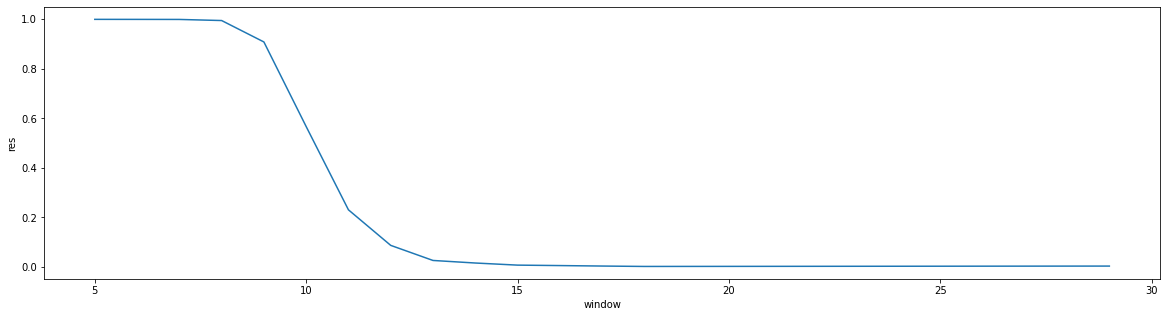

In [108]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=plot_dataframe, x='window', y='res', palette='bright', markers=True)
plt.savefig('window.png')